Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('credit_card_default_analysis.csv', sep=",", index_col=False)

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [5]:
data.SEX.value_counts()[1]/float(data.shape[0])

0.39626666666666666

__Размер кредитного лимита (LIMIT_BAL).__ В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

In [6]:
kept = data[data.default == 1]
returned = data[data.default == 0]

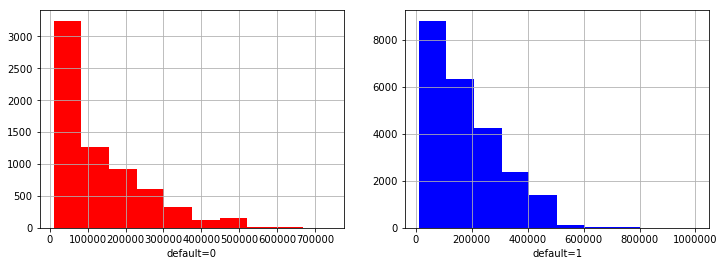

In [7]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(kept.LIMIT_BAL, color = 'r')
pylab.xlabel('default=0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(returned.LIMIT_BAL, color = 'b')
pylab.xlabel('default=1')

pylab.show()

## 95% confidence interval for median of credil limit

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

returned_median_scores = map(np.median, get_bootstrap_samples(returned.LIMIT_BAL.values,1000))
kept_median_scores = map(np.median, get_bootstrap_samples(kept.LIMIT_BAL.values, 1000))

print "Interval for who returned the loan:",  stat_intervals(returned_median_scores, 0.05)
print "Interval for who doesn't returned the loan:",  stat_intervals(kept_median_scores, 0.05)

Interval for who returned the loan: [ 150000.  150000.]
Interval for who doesn't returned the loan: [ 80000.  90000.]


Медианы не равны

## Проверим гипотезу о равенстве распределений с помощью перестановочного критерия

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [11]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [12]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [13]:
a = permutation_zero_dist_ind(kept.LIMIT_BAL, returned.LIMIT_BAL, max_combinations = 1000)
index = np.where(np.array(a) < -10000)[0][0]
a = numpy.delete(a, index)

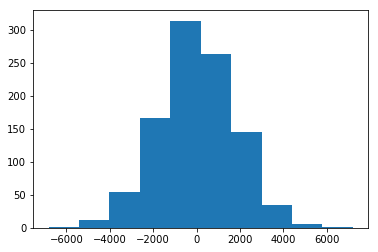

In [14]:
pylab.hist(a)
pylab.show()

In [15]:
def permutation_test(sample, mean, max_permutations = None):
    
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    #index = np.where(np.array(zero_distr) < -10000)[0][0]
    #zero_distr = numpy.delete(zero_distr, index)
        
    return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [16]:
print "p-value: %f" % permutation_test(kept.LIMIT_BAL, returned.LIMIT_BAL, max_permutations = 1000)

p-value: 0.001000


### Гипотеза о равенстве средних отвергается против 2-х сторонней альтернативы на уровне 0.05!

__Пол (SEX):__ Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [15]:
import scipy

In [16]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = sample1.value_counts()[1]/ float(sample1.shape[0])
    p2 = sample2.value_counts()[1]/ float(sample2.shape[0])
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ float(sample1.shape[0]) + p2 * (1 - p2)/ float(sample2.shape[0]))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ float(sample1.shape[0]) + p2 * (1 - p2)/ float(sample2.shape[0]))
    
    return (left_boundary, right_boundary)

In [17]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(kept.SEX, returned.SEX)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


Гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается отвергается, поскольку доверительный интервал не содержит 0

In [18]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = float(sample1.shape[0])
    n2 = float(sample2.shape[0])
    
    p1 = sample1.value_counts()[1] / n1
    p2 = sample2.value_counts()[1] / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [19]:
def proportions_diff_z_test(z_stat):
    return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

In [20]:
print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(kept.SEX, returned.SEX))

p-value: 0.000000


Z-критерий также отвергает нулевую гипотезу

__Образование (EDUCATION):__ Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборот, не отдаст долг ?

- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных ).

In [21]:
from scipy.stats import chi2_contingency

In [22]:
table = np.zeros(14).reshape((7,2))

In [23]:
for j in range(2):
    for i in range(7):
        if (j == 0):
            table[i,j] = returned.EDUCATION.value_counts()[i]
        if (j == 1) & (i > 0):
            table[i,j] = kept.EDUCATION.value_counts()[i]

In [24]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table)
print p

1.23326262454e-32


Нулевая гипотеза о том, что образование не играет роли отвергается

### Приведем знаения ячеек к одному масштабу, отнормировав на количество событий в каждой категории:

In [25]:
diff = table - expected

In [26]:
scaled_diff=diff
for i in range(7):
    scaled_diff[i,0] = diff[i,0]/sum(table[i,:])
    scaled_diff[i,1] = diff[i,1]/sum(table[i,:])
scaled_diff

array([[ 0.2212    , -0.2212    ],
       [ 0.02885234, -0.02885234],
       [-0.01614854,  0.01614854],
       [-0.03037616,  0.03037616],
       [ 0.16428943, -0.16428943],
       [ 0.15691429, -0.15691429],
       [ 0.06433725, -0.06433725]])

#### Видно что, Выпускники школы наиболее вероятны не вернуть кредит, в то время как доктора самые надежные!

__Семейное положение (MARRIAGE):__ Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [27]:
table = np.zeros(8).reshape((4,2))

In [28]:
for j in range(2):
    for i in range(4):
        if (j == 0):
            table[i,j] = returned.MARRIAGE.value_counts()[i]
        if (j == 1):
            table[i,j] = kept.MARRIAGE.value_counts()[i]

In [29]:
table

array([[  4.90000000e+01,   5.00000000e+00],
       [  1.04530000e+04,   3.20600000e+03],
       [  1.26230000e+04,   3.34100000e+03],
       [  2.39000000e+02,   8.40000000e+01]])

Первый столбец - количество возвратов, второй - количество дефолтов. Строки соответствуют следующим значениям - MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [30]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table)
print p

8.82586245758e-08


Нулевая гипотеза о том, что семейное положение не играет роли отвергается

In [31]:
diff = table - expected

In [32]:
scaled_diff=diff
for i in range(4):
    scaled_diff[i,0] = diff[i,0]/sum(table[i,:])
    scaled_diff[i,1] = diff[i,1]/sum(table[i,:])
scaled_diff

array([[ 0.12860741, -0.12860741],
       [-0.01351704,  0.01351704],
       [ 0.01191661, -0.01191661],
       [-0.03886192,  0.03886192]])

Практически значимой разности между значениями нет.

__Возраст (AGE):__ Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [33]:
np.random.seed(0)

age0_median_scores = map(np.median, get_bootstrap_samples(returned.AGE.values,1000))
age1_median_scores = map(np.median, get_bootstrap_samples(kept.AGE.values, 1000))

print "95% confidence interval for the credit limit without default:",  stat_intervals(age0_median_scores, 0.05)
print "95% confidence interval for the credit limit with default:",  stat_intervals(age1_median_scores, 0.05)

95% confidence interval for the credit limit without default: [ 34.  34.]
95% confidence interval for the credit limit with default: [ 34.  35.]


Доверительные интервалы пересекаются, а следовательно гипотеза о равенстве медианных возрастов 2-х групп не отвергается. Разность медиан можно признать практически не значимой

In [34]:
print "p-value: %f" % permutation_test(returned.AGE.values, kept.AGE.values, max_permutations = 1000)

p-value: 0.007000


Нулевая гипотеза о равенстве средних отвергается против 2-х сторонней альтернативы на уровне 0.05.